In [2]:
#General libraries
import os
import pandas as pd
import numpy as np

#Graph tools
import matplotlib.pyplot as plt 
import seaborn as sns

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler

#Optimization
import optuna

In [25]:
train_path = os.path.join('data', 'train.csv')
train_extra_path = os.path.join('data', 'train_extra.csv')
test_path = os.path.join('data', 'test.csv')
sample_submission_path = os.path.join('data', 'sample_submission.csv')

raw_train_data = pd.read_csv(train_path, index_col= 'id')
train_extra = pd.read_csv(train_extra_path)
train_extra['rainfall'] = train_extra['rainfall'].map({'yes': 1, 'no': 0})
ord_cols = raw_train_data.columns
train_extra.columns = train_extra.columns.str.strip()
train_extra = train_extra[ord_cols]

raw_train_data = pd.concat([raw_train_data, train_extra], ignore_index=True)

raw_test_data = pd.read_csv(test_path, index_col = 'id')
sample_submission = pd.read_csv(sample_submission_path)

raw_train_data.drop_duplicates(inplace= True)

In [26]:
raw_train_data

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2551,27,1022.7,18.8,17.7,16.9,15.0,84.0,90.0,0.0,30.0,18.4,1
2552,28,1026.6,18.6,17.3,16.3,12.8,75.0,85.0,1.0,20.0,25.9,1
2553,29,1025.9,18.9,17.7,16.4,13.3,75.0,78.0,4.6,70.0,33.4,1
2554,30,1025.3,19.2,17.3,15.2,13.3,78.0,86.0,1.2,20.0,20.9,1


In [27]:
print(raw_train_data.shape)
raw_train_data.head()

(2556, 12)


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


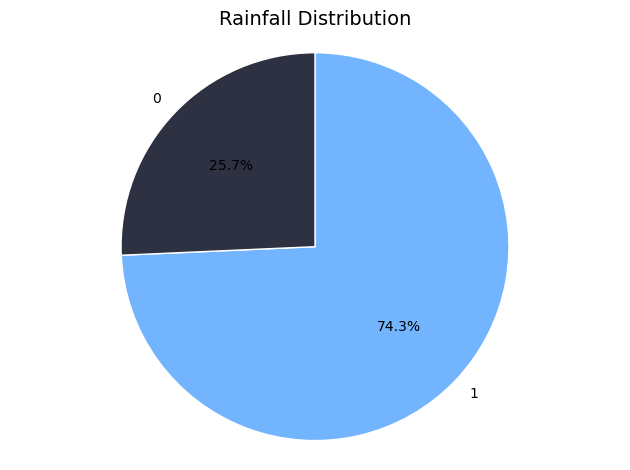

In [28]:
colors = ['#73B4FF', '#2D3142']
value_counts = raw_train_data['rainfall'].value_counts(normalize= True)
labels = value_counts.index.astype(str)
sizes = value_counts.values
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    counterclock=False,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    colors= colors
)
ax.axis('equal')

# Agregar título
ax.set_title('Rainfall Distribution', fontsize=14)

plt.tight_layout()
plt.show()

In [29]:
raw_train_data.skew()

day              0.212063
pressure         0.296105
maxtemp         -0.498691
temparature     -0.572837
mintemp         -0.665619
dewpoint        -1.017838
humidity        -0.746113
cloud           -1.314987
sunshine         0.599634
winddirection    0.721490
windspeed        0.769942
rainfall        -1.112580
dtype: float64

In [30]:
imputer = SimpleImputer(strategy= 'median')

def data_preproccesing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['cloud'] = np.log1p(df['cloud'])
    df['temp_change'] = df['maxtemp']-df['mintemp']
    df['temp_ratio'] = df['maxtemp']/df['mintemp']
    df['wind_dir_rad'] = np.deg2rad(df['winddirection'])
    df['wind_direction_sin'] = np.sin(df['wind_dir_rad'])
    df['wind_direction_cos'] = np.cos(df['wind_dir_rad'])
    df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2
    df['dewpoint_depression'] = df['temparature'] - df['dewpoint']
    df['sunshine_ratio'] = df['sunshine'] / (1 + df['cloud'])

    df.drop(columns=['winddirection'], inplace=True)
    
    df_imputed = imputer.fit_transform(df)
    df = pd.DataFrame(df_imputed, columns= df.columns)

    for col in df.columns:
        df[col +'_cat'] = df[col].astype(str)
        df[col +'_cat'] = df[col + '_cat'].astype('category')

    return df

def test_data_preproccesing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['cloud'] = np.log1p(df['cloud'])
    df['temp_change'] = df['maxtemp']-df['mintemp']
    df['temp_ratio'] = df['maxtemp']/df['mintemp']
    df['wind_dir_rad'] = np.deg2rad(df['winddirection'])
    df['wind_direction_sin'] = np.sin(df['wind_dir_rad'])
    df['wind_direction_cos'] = np.cos(df['wind_dir_rad'])
    df['avg_temp'] = (df['maxtemp'] + df['mintemp']) / 2
    df['dewpoint_depression'] = df['temparature'] - df['dewpoint']
    df['sunshine_ratio'] = df['sunshine'] / (1 + df['cloud'])

    df.drop(columns=['winddirection'], inplace=True)
    
    df_imputed = imputer.transform(df)
    df = pd.DataFrame(df_imputed, columns= df.columns)
    for col in df.columns:
        df[col +'_cat'] = df[col].astype(str)
        df[col +'_cat'] = df[col + '_cat'].astype('category')

    return df

In [31]:
X_train = raw_train_data.drop(columns= 'rainfall')
y_train = raw_train_data['rainfall']
X_train = data_preproccesing(X_train) 

In [32]:
X_train

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,...,sunshine_cat,windspeed_cat,temp_change_cat,temp_ratio_cat,wind_dir_rad_cat,wind_direction_sin_cat,wind_direction_cos_cat,avg_temp_cat,dewpoint_depression_cat,sunshine_ratio_cat
0,1.0,1017.4,21.2,20.6,19.9,19.4,87.0,4.488636,1.1,17.2,...,1.1,17.2,1.3000000000000007,1.065326633165829,1.0471975511965976,0.8660254037844386,0.5000000000000001,20.549999999999997,1.2000000000000028,0.20041407845236486
1,2.0,1019.5,16.2,16.9,15.8,15.4,95.0,4.521789,0.0,21.9,...,0.0,21.9,0.3999999999999986,1.0253164556962024,0.8726646259971648,0.766044443118978,0.6427876096865394,16.0,1.4999999999999982,0.0
2,3.0,1024.1,19.4,16.1,14.6,9.3,75.0,3.871201,8.3,18.1,...,8.3,18.1,4.799999999999999,1.3287671232876712,1.2217304763960306,0.9396926207859083,0.3420201433256688,17.0,6.800000000000001,1.7038919111352897
3,4.0,1013.4,18.1,17.8,16.9,16.8,95.0,4.564348,0.0,35.6,...,0.0,35.6,1.2000000000000028,1.0710059171597635,1.0471975511965976,0.8660254037844386,0.5000000000000001,17.5,1.0,0.0
4,5.0,1021.8,21.3,18.4,15.2,9.6,52.0,3.828641,3.6,24.8,...,3.6,24.8,6.100000000000001,1.4013157894736843,0.6981317007977318,0.6427876096865393,0.766044443118978,18.25,8.799999999999999,0.7455513268426932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,27.0,1022.7,18.8,17.7,16.9,15.0,84.0,4.510860,0.0,18.4,...,0.0,18.4,1.9000000000000021,1.1124260355029587,0.5235987755982988,0.49999999999999994,0.8660254037844387,17.85,2.6999999999999993,0.0
2552,28.0,1026.6,18.6,17.3,16.3,12.8,75.0,4.454347,1.0,25.9,...,1.0,25.9,2.3000000000000007,1.1411042944785277,0.3490658503988659,0.3420201433256687,0.9396926207859084,17.450000000000003,4.5,0.18333999389567326
2553,29.0,1025.9,18.9,17.7,16.4,13.3,75.0,4.369448,4.6,33.4,...,4.6,33.4,2.5,1.1524390243902438,1.2217304763960306,0.9396926207859083,0.3420201433256688,17.65,4.399999999999999,0.8566988871838107
2554,30.0,1025.3,19.2,17.3,15.2,13.3,78.0,4.465908,1.2,20.9,...,1.2,20.9,4.0,1.263157894736842,0.3490658503988659,0.3420201433256687,0.9396926207859084,17.2,4.0,0.219542658594008


In [33]:
def objective(trial, X, y):
    # Define hyperparameters in a dictionary (best practice)
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 1, 8, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 10),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.001, 0.5),
        'random_state': 42
    }
    
    clf = DecisionTreeClassifier(**params)
    
    # 5-split StratifiedKFold to maintain class balance
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_scores = []
    val_scores = []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        clf.fit(X_train, y_train)
        # Use predicted probabilities for ROC AUC calculation
        train_proba = clf.predict_proba(X_train)[:, 1]
        val_proba = clf.predict_proba(X_test)[:, 1]
        train_scores.append(roc_auc_score(y_train, train_proba))
        val_scores.append(roc_auc_score(y_test, val_proba))
    
    avg_train_auc = np.mean(train_scores)
    avg_val_auc = np.mean(val_scores)
    
    # Print out trial metrics immediately after evaluation
    print(f"Trial {trial.number} - Train AUC: {avg_train_auc:.4f} | Validation AUC: {avg_val_auc:.4f}")
    
    return avg_val_auc

In [34]:
study = optuna.create_study(direction='maximize', sampler= optuna.samplers.TPESampler(seed= 42))
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

[I 2025-03-09 20:38:42,096] A new study created in memory with name: no-name-ad9bfadd-824a-4a1f-95f3-a02321bb3658
[I 2025-03-09 20:38:42,189] Trial 0 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 0.2403950683025824, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 2, 'min_impurity_decrease': 0.48498501622883516}. Best is trial 0 with value: 0.5.
[I 2025-03-09 20:38:42,249] Trial 1 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 0.5722807884690141, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 4, 'min_impurity_decrease': 0.18381455980355216}. Best is trial 0 with value: 0.5.
[I 2025-03-09 20:38:42,306] Trial 2 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': 0.1418053

Trial 0 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 1 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 2 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 3 - Train AUC: 0.5000 | Validation AUC: 0.5000


[I 2025-03-09 20:38:42,419] Trial 4 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 19, 'max_features': 0.905344615384884, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 2, 'min_impurity_decrease': 0.1633398350508689}. Best is trial 0 with value: 0.5.
[I 2025-03-09 20:38:42,476] Trial 5 finished with value: 0.7473694250705343 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 0.5884264748424236, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.10015912508555203}. Best is trial 5 with value: 0.7473694250705343.
[I 2025-03-09 20:38:42,535] Trial 6 finished with value: 0.7667851459189283 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 16, 'max_features': 0.16664018656068133, 'splitter': 'best', 'class_weight': None, 'max_leaf_n

Trial 4 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 5 - Train AUC: 0.7553 | Validation AUC: 0.7474
Trial 6 - Train AUC: 0.7905 | Validation AUC: 0.7668
Trial 7 - Train AUC: 0.5000 | Validation AUC: 0.5000


[I 2025-03-09 20:38:42,643] Trial 8 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.6727693701374023, 'splitter': 'random', 'class_weight': None, 'max_leaf_nodes': 5, 'min_impurity_decrease': 0.3780200181329813}. Best is trial 6 with value: 0.7667851459189283.
[I 2025-03-09 20:38:42,697] Trial 9 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 19, 'max_features': 0.8273083416079753, 'splitter': 'random', 'class_weight': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.2701317787159097}. Best is trial 6 with value: 0.7667851459189283.
[I 2025-03-09 20:38:42,765] Trial 10 finished with value: 0.8313371115228907 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': 0.3454181894809759, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'm

Trial 8 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 9 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 10 - Train AUC: 0.8353 | Validation AUC: 0.8313
Trial 11 - Train AUC: 0.8603 | Validation AUC: 0.8514


[I 2025-03-09 20:38:42,902] Trial 12 finished with value: 0.8513520167155569 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': 0.32924553145380836, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.002550069392084447}. Best is trial 11 with value: 0.8513520167155569.
[I 2025-03-09 20:38:42,971] Trial 13 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 0.36573605737753084, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.08060591825511665}. Best is trial 11 with value: 0.8513520167155569.
[I 2025-03-09 20:38:43,039] Trial 14 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 12, 'max_features': 0.3768738322069716, 'splitter': 'best', 'cl

Trial 12 - Train AUC: 0.8603 | Validation AUC: 0.8514
Trial 13 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 14 - Train AUC: 0.8157 | Validation AUC: 0.8157


[I 2025-03-09 20:38:43,107] Trial 15 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 15, 'max_features': 0.27966334275564725, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.020469483333173666}. Best is trial 11 with value: 0.8513520167155569.
[I 2025-03-09 20:38:43,178] Trial 16 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 0.43966696949367695, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.15741563305496015}. Best is trial 11 with value: 0.8513520167155569.
[I 2025-03-09 20:38:43,255] Trial 17 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': 0.7207069826905906, 'splitter': 'best', 'c

Trial 15 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 16 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 17 - Train AUC: 0.8157 | Validation AUC: 0.8157


[I 2025-03-09 20:38:43,329] Trial 18 finished with value: 0.8245095472529759 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 17, 'max_features': 0.24381598610926306, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.007619450566420747}. Best is trial 11 with value: 0.8513520167155569.
[I 2025-03-09 20:38:43,400] Trial 19 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.4523994979938132, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.13711341097790772}. Best is trial 11 with value: 0.8513520167155569.
[I 2025-03-09 20:38:43,462] Trial 20 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 11, 'max_features': 0.11351909046311837, 'splitter': 'best', 'class_weight': Non

Trial 18 - Train AUC: 0.8553 | Validation AUC: 0.8245
Trial 19 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 20 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 21 - Train AUC: 0.8598 | Validation AUC: 0.8518


[I 2025-03-09 20:38:43,530] Trial 21 finished with value: 0.8518012621248694 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 14, 'max_features': 0.34201673373437114, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.003660489071432396}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:43,608] Trial 22 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': 0.29135690507204315, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.05692407354938256}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:43,680] Trial 23 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 14, 'max_features': 0.4693572880419793, 'splitter': 'best', 'c

Trial 22 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 23 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 24 - Train AUC: 0.8238 | Validation AUC: 0.8053


[I 2025-03-09 20:38:43,815] Trial 25 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': 0.3551122314732951, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.05639878874651404}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:43,881] Trial 26 finished with value: 0.69909355092205 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': 0.18776707529158346, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 5, 'min_impurity_decrease': 0.1123676002879718}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:43,945] Trial 27 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 16, 'max_features': 0.41192250417707676, 'splitter': 'best', 'class_weight': 

Trial 25 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 26 - Train AUC: 0.7044 | Validation AUC: 0.6991
Trial 27 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 28 - Train AUC: 0.8157 | Validation AUC: 0.8157


[I 2025-03-09 20:38:44,081] Trial 29 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 0.6561152501439431, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.4913308565632081}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:44,144] Trial 30 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': 0.2282294919602461, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 2, 'min_impurity_decrease': 0.42277692954979296}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:44,213] Trial 31 finished with value: 0.8518012621248694 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': 0.3393960481018823, 'splitter': 'best', 'class_weight': None, 'max_lea

Trial 29 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 30 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 31 - Train AUC: 0.8598 | Validation AUC: 0.8518


[I 2025-03-09 20:38:44,286] Trial 32 finished with value: 0.8489418886853656 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 14, 'max_features': 0.5014810987996884, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.0013326366323867982}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:44,353] Trial 33 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_features': 0.31187592583295326, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.042058453811372125}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:44,418] Trial 34 finished with value: 0.7949884374914773 and parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 18, 'min_samples_leaf': 15, 'max_features': 0.39534727187707686, 'splitter': 'best', 'cl

Trial 32 - Train AUC: 0.8616 | Validation AUC: 0.8489
Trial 33 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 34 - Train AUC: 0.8012 | Validation AUC: 0.7950


[I 2025-03-09 20:38:44,488] Trial 35 finished with value: 0.7587734031658222 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 16, 'max_features': 0.2513382876714612, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.08126489725403832}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:44,550] Trial 36 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 0.591286719788535, 'splitter': 'random', 'class_weight': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.20685875977119283}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:44,619] Trial 37 finished with value: 0.8380759527577373 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 0.18125500518736723, 'splitter': 'best', 'class_weight': 

Trial 35 - Train AUC: 0.7622 | Validation AUC: 0.7588
Trial 36 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 37 - Train AUC: 0.8436 | Validation AUC: 0.8381
Trial 38 - Train AUC: 0.8309 | Validation AUC: 0.8256


[I 2025-03-09 20:38:44,756] Trial 39 finished with value: 0.8157446740231254 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 17, 'max_features': 0.48298935170925134, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.14022035305310543}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:44,818] Trial 40 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 18, 'max_features': 0.32584453840763944, 'splitter': 'random', 'class_weight': None, 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.32984451567552153}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:44,890] Trial 41 finished with value: 0.8489418886853656 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 14, 'max_features': 0.4888373703821325, 'splitter': 'best', 'class_weight

Trial 39 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 40 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 41 - Train AUC: 0.8616 | Validation AUC: 0.8489


[I 2025-03-09 20:38:44,963] Trial 42 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 14, 'max_features': 0.5430375059991775, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.04120503715370577}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:45,031] Trial 43 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': 0.3427482328179246, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.06759877138142739}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:45,102] Trial 44 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 15, 'max_features': 0.4088131399075152, 'splitter': 'best', 'clas

Trial 42 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 43 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 44 - Train AUC: 0.8157 | Validation AUC: 0.8157


[I 2025-03-09 20:38:45,170] Trial 45 finished with value: 0.7949884374914773 and parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_features': 0.6055108643204481, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.0253335734777178}. Best is trial 21 with value: 0.8518012621248694.
[I 2025-03-09 20:38:45,249] Trial 46 finished with value: 0.8615353033076889 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 14, 'max_features': 0.5098327405859582, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.0014674392451912114}. Best is trial 46 with value: 0.8615353033076889.
[I 2025-03-09 20:38:45,310] Trial 47 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 13, 'max_features': 0.2676516227016205, 'splitter': 'random', 'class_weight': None

Trial 45 - Train AUC: 0.8012 | Validation AUC: 0.7950
Trial 46 - Train AUC: 0.8761 | Validation AUC: 0.8615
Trial 47 - Train AUC: 0.5000 | Validation AUC: 0.5000


[I 2025-03-09 20:38:45,381] Trial 48 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 16, 'max_features': 0.4274132855075187, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.08237777976254793}. Best is trial 46 with value: 0.8615353033076889.
[I 2025-03-09 20:38:45,465] Trial 49 finished with value: 0.8313371115228907 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 15, 'max_features': 0.7969477545541308, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 5, 'min_impurity_decrease': 0.023829538434971095}. Best is trial 46 with value: 0.8615353033076889.
[I 2025-03-09 20:38:45,534] Trial 50 finished with value: 0.7949884374914773 and parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 11, 'max_features': 0.3792746335346372, 'splitter': 'best', 'class_

Trial 48 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 49 - Train AUC: 0.8353 | Validation AUC: 0.8313
Trial 50 - Train AUC: 0.8012 | Validation AUC: 0.7950


[I 2025-03-09 20:38:45,608] Trial 51 finished with value: 0.8313371115228907 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 14, 'max_features': 0.520788478159429, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.025547185646711094}. Best is trial 46 with value: 0.8615353033076889.
[I 2025-03-09 20:38:45,692] Trial 52 finished with value: 0.849761362965787 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': 0.5114231883220797, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.0097810457203723}. Best is trial 46 with value: 0.8615353033076889.
[I 2025-03-09 20:38:45,770] Trial 53 finished with value: 0.8313371115228907 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 0.5678340994634141, 'splitter': 'best', 'class_w

Trial 51 - Train AUC: 0.8353 | Validation AUC: 0.8313
Trial 52 - Train AUC: 0.8660 | Validation AUC: 0.8498
Trial 53 - Train AUC: 0.8353 | Validation AUC: 0.8313


[I 2025-03-09 20:38:45,846] Trial 54 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 16, 'max_features': 0.6317647131542741, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.06731193294095898}. Best is trial 46 with value: 0.8615353033076889.
[I 2025-03-09 20:38:45,929] Trial 55 finished with value: 0.8687363562142444 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 13, 'max_features': 0.4505974613350596, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.0016343760211967192}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:46,000] Trial 56 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 0.43280027001724264, 'splitter': 'best', 'cl

Trial 54 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 55 - Train AUC: 0.8870 | Validation AUC: 0.8687
Trial 56 - Train AUC: 0.8157 | Validation AUC: 0.8157


[I 2025-03-09 20:38:46,071] Trial 57 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 13, 'max_features': 0.3550465225641224, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.0899577625772152}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:46,136] Trial 58 finished with value: 0.7084656312834439 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 12, 'max_features': 0.4620519314668108, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.11381030263464192}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:46,200] Trial 59 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 0.27218624868294106, 'splitter': 'best', 'class_weigh

Trial 57 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 58 - Train AUC: 0.7085 | Validation AUC: 0.7085
Trial 59 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 60 - Train AUC: 0.8157 | Validation AUC: 0.8157


[I 2025-03-09 20:38:46,345] Trial 61 finished with value: 0.8313371115228907 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 0.538946356917072, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.016762285328331232}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:46,425] Trial 62 finished with value: 0.8680380065909574 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': 0.4444438424112552, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.006699034949340472}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:46,496] Trial 63 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': 0.3857042464251445, 'splitter': 'best', 'clas

Trial 61 - Train AUC: 0.8353 | Validation AUC: 0.8313
Trial 62 - Train AUC: 0.8805 | Validation AUC: 0.8680
Trial 63 - Train AUC: 0.8157 | Validation AUC: 0.8157


[I 2025-03-09 20:38:46,566] Trial 64 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 17, 'max_features': 0.33329070719852727, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.03683358785049401}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:46,639] Trial 65 finished with value: 0.8321703010235522 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': 0.4236022201437204, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.015464190636284948}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:46,711] Trial 66 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': 0.4526378013507995, 'splitter': 'best', 'cl

Trial 64 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 65 - Train AUC: 0.8362 | Validation AUC: 0.8322
Trial 66 - Train AUC: 0.8157 | Validation AUC: 0.8157


[I 2025-03-09 20:38:46,790] Trial 67 finished with value: 0.8646460983456337 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 12, 'max_features': 0.3721896786361689, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.0048417691038499765}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:46,863] Trial 68 finished with value: 0.8455778031879488 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 0.2006955851144923, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.001104185783040692}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:46,932] Trial 69 finished with value: 0.7949884374914773 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': 0.3702399128649485, 'splitter': 'best', 'clas

Trial 67 - Train AUC: 0.8795 | Validation AUC: 0.8646
Trial 68 - Train AUC: 0.8625 | Validation AUC: 0.8456
Trial 69 - Train AUC: 0.8012 | Validation AUC: 0.7950


[I 2025-03-09 20:38:47,000] Trial 70 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 0.4697187566954386, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 5, 'min_impurity_decrease': 0.3686089648186402}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:47,069] Trial 71 finished with value: 0.818187306149135 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 14, 'max_features': 0.32906119754700014, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.03102081038718422}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:47,143] Trial 72 finished with value: 0.8352547526779942 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': 0.39680045794937846, 'splitter': 'best', 'class_weight':

Trial 70 - Train AUC: 0.5000 | Validation AUC: 0.5000
Trial 71 - Train AUC: 0.8194 | Validation AUC: 0.8182
Trial 72 - Train AUC: 0.8440 | Validation AUC: 0.8353


[I 2025-03-09 20:38:47,210] Trial 73 finished with value: 0.6211251359343227 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 12, 'max_features': 0.28603469487301914, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.24754058023304043}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:47,279] Trial 74 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 16, 'max_features': 0.35849731528085066, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.036816110612888454}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:47,349] Trial 75 finished with value: 0.8336380013291393 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 0.314744080790392, 'splitter': 'best', 'cl

Trial 73 - Train AUC: 0.6276 | Validation AUC: 0.6211
Trial 74 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 75 - Train AUC: 0.8406 | Validation AUC: 0.8336


[I 2025-03-09 20:38:47,412] Trial 76 finished with value: 0.8416540585805496 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 14, 'max_features': 0.21904554725308487, 'splitter': 'random', 'class_weight': None, 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.0015166944844509378}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:47,483] Trial 77 finished with value: 0.7812512146271612 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 0.25222109653058505, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.057535279822205715}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:47,550] Trial 78 finished with value: 0.5 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 13, 'max_features': 0.4369053967749413, 'splitter': 'best', 'class_weight

Trial 76 - Train AUC: 0.8422 | Validation AUC: 0.8417
Trial 77 - Train AUC: 0.7989 | Validation AUC: 0.7813
Trial 78 - Train AUC: 0.5000 | Validation AUC: 0.5000


[I 2025-03-09 20:38:47,624] Trial 79 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 12, 'max_features': 0.4025573097912747, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 6, 'min_impurity_decrease': 0.03546132844892138}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:47,693] Trial 80 finished with value: 0.7977748770853047 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 0.3472791877877897, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.01688501882367055}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:47,773] Trial 81 finished with value: 0.8485781568589168 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': 0.5168651705906864, 'splitter': 'best', 'c

Trial 79 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 80 - Train AUC: 0.8050 | Validation AUC: 0.7978
Trial 81 - Train AUC: 0.8638 | Validation AUC: 0.8486


[I 2025-03-09 20:38:47,855] Trial 82 finished with value: 0.8654635084947045 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': 0.5581077511176169, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.002220561864675026}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:47,932] Trial 83 finished with value: 0.8313371115228907 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': 0.5756250578578447, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 7, 'min_impurity_decrease': 0.029042139018867173}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:48,007] Trial 84 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 15, 'max_features': 0.5508358746532672, 'splitter': 'best', 'cl

Trial 82 - Train AUC: 0.8819 | Validation AUC: 0.8655
Trial 83 - Train AUC: 0.8353 | Validation AUC: 0.8313
Trial 84 - Train AUC: 0.8157 | Validation AUC: 0.8157


[I 2025-03-09 20:38:48,101] Trial 85 finished with value: 0.8607281028690628 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 11, 'max_features': 0.6960369697735094, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0034478659220432404}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:48,183] Trial 86 finished with value: 0.8262462351336366 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': 0.7366699592114139, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.027464631382999424}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:48,277] Trial 87 finished with value: 0.8652833289613341 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': 0.6904317325698894, 'splitter': 'best', 

Trial 85 - Train AUC: 0.8913 | Validation AUC: 0.8607
Trial 86 - Train AUC: 0.8309 | Validation AUC: 0.8262
Trial 87 - Train AUC: 0.8904 | Validation AUC: 0.8653


[I 2025-03-09 20:38:48,341] Trial 88 finished with value: 0.7482789157557506 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_features': 0.6844253717863062, 'splitter': 'random', 'class_weight': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.04791483023824089}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:48,439] Trial 89 finished with value: 0.8634310282826589 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 13, 'max_features': 0.7396350004653994, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.002228189689362341}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:48,519] Trial 90 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': 0.765236873318103, 'splitter': 'best', '

Trial 88 - Train AUC: 0.7517 | Validation AUC: 0.7483
Trial 89 - Train AUC: 0.8907 | Validation AUC: 0.8634
Trial 90 - Train AUC: 0.8157 | Validation AUC: 0.8157


[I 2025-03-09 20:38:48,615] Trial 91 finished with value: 0.8513881739283455 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 13, 'max_features': 0.8355637487827554, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.010503765694252973}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:48,713] Trial 92 finished with value: 0.8652833289613341 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_features': 0.6843886037270919, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0024106144472928028}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:48,793] Trial 93 finished with value: 0.8201259516446605 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 0.6884791515199796, 'splitter': 'best', 

Trial 91 - Train AUC: 0.8679 | Validation AUC: 0.8514
Trial 92 - Train AUC: 0.8904 | Validation AUC: 0.8653
Trial 93 - Train AUC: 0.8237 | Validation AUC: 0.8201


[I 2025-03-09 20:38:48,871] Trial 94 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 12, 'max_features': 0.7135739080857151, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.06459503334903485}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:48,949] Trial 95 finished with value: 0.8157446740231254 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': 0.6433230722670085, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.03725747392620167}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:49,029] Trial 96 finished with value: 0.8313371115228907 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 0.6157581053930747, 'splitter': 'best', 'clas

Trial 94 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 95 - Train AUC: 0.8157 | Validation AUC: 0.8157
Trial 96 - Train AUC: 0.8353 | Validation AUC: 0.8313


[I 2025-03-09 20:38:49,138] Trial 97 finished with value: 0.8631766670688521 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_features': 0.7829804861815757, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.00405962802615344}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:49,249] Trial 98 finished with value: 0.8625172828487239 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 12, 'max_features': 0.8715527090951254, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.002366754534080221}. Best is trial 55 with value: 0.8687363562142444.
[I 2025-03-09 20:38:49,336] Trial 99 finished with value: 0.826505853989745 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 12, 'max_features': 0.8582183803509561, 'splitter': 'best', 'cla

Trial 97 - Train AUC: 0.8886 | Validation AUC: 0.8632
Trial 98 - Train AUC: 0.8917 | Validation AUC: 0.8625
Trial 99 - Train AUC: 0.8320 | Validation AUC: 0.8265


In [25]:
best_params = {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 13, 'max_features': 0.4505974613350596, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.0016343760211967192}
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4,
                       max_features=0.29119028317832424, max_leaf_nodes=9,
                       min_impurity_decrease=0.0013326366323867982,
                       min_samples_leaf=19, min_samples_split=13)

In [26]:
X_test = test_data_preproccesing(raw_test_data)

In [27]:
predictions = best_model.predict_proba(X_test)[:, 1]

In [28]:
sample_submission['rainfall'] = predictions

In [29]:
sample_submission.to_csv('submission.csv', index= False)